In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("Train.csv")
train['Datetime'] = pd.to_datetime(train.Datetime, format='%Y/%m/%d')
test = pd.read_csv("Test.csv")
test['Datetime'] = pd.to_datetime(test.Datetime, format='%Y/%m/%d')

# train = np.asarray(df_train.iloc[:,1])
# test = np.asarray(df_test.iloc[:,1])

# 一阶差分

In [3]:
new=train.diff(periods=1).dropna()
newtest=test.diff(periods=1).dropna()

In [4]:
new,newtest

(     Datetime  DailyMaximumDryBulbTemperature
 1      1 days                             3.0
 2      1 days                            -6.0
 3      1 days                             1.0
 4      1 days                             3.0
 5      1 days                            10.0
 ...       ...                             ...
 2871   1 days                             2.0
 2872   1 days                             2.0
 2873   1 days                             3.0
 2874   1 days                            -1.0
 2875   1 days                             1.0
 
 [2875 rows x 2 columns],
     Datetime  DailyMaximumDryBulbTemperature
 1     1 days                             0.0
 2     1 days                             1.0
 3     1 days                            -1.0
 4     1 days                             1.0
 5     1 days                            -2.0
 ..       ...                             ...
 715   1 days                            -2.0
 716   1 days                           

# 平稳性检验

In [5]:
dftest = adfuller(new['DailyMaximumDryBulbTemperature'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -19.848226
p-value                           0.000000
#Lags Used                       15.000000
Number of Observations Used    2859.000000
Critical Value (1%)              -3.432639
Critical Value (5%)              -2.862551
Critical Value (10%)             -2.567308
dtype: float64


# ACF PACF图形定阶

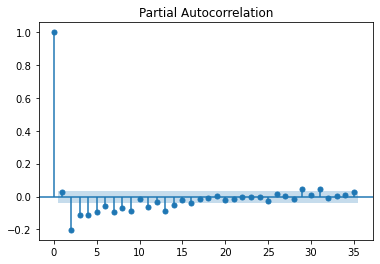

In [6]:
plot_pacf(new['DailyMaximumDryBulbTemperature'])
plt.show()

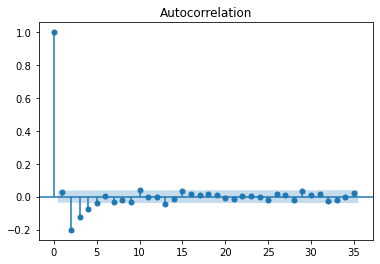

In [7]:
plot_acf(new['DailyMaximumDryBulbTemperature'])
plt.show()

In [8]:
# model = AR(train['DailyMaximumDryBulbTemperature'])
x =ar_select_order(new['DailyMaximumDryBulbTemperature'],20,ic='bic')
x.ar_lags

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [9]:
model = AR(new['DailyMaximumDryBulbTemperature'],train['Datetime'])
res=model.fit(maxlag = 15,ic='bic')
res.k_ar

14

### 通过图形定阶、信息准则等方法，我们将参数p选为14

In [10]:
ar = AutoReg(new['DailyMaximumDryBulbTemperature'],lags=14,trend='n',seasonal=True,period=365).fit() 
ar_fit = ar.predict(start=14,end=len(train)-2) 
ar_pre = ar.predict(start=len(train),end=len(train)+len(test)-1)  # 这里是预测了

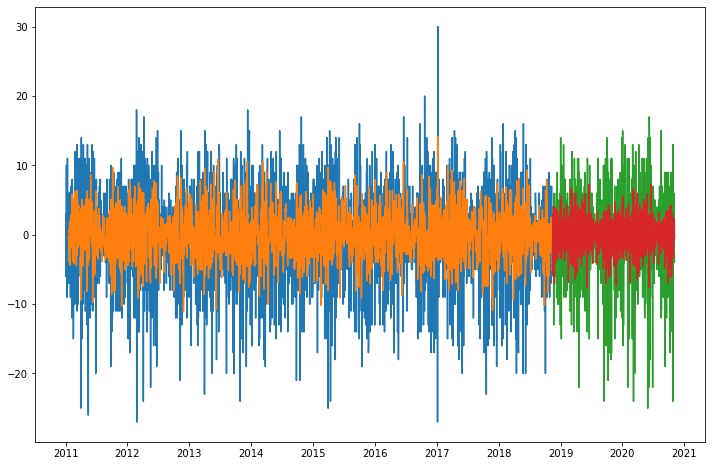

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(train.Datetime[1:], new['DailyMaximumDryBulbTemperature'], label='Train')
plt.plot(train.Datetime[15:], ar_fit, label='AR fit') 
plt.plot(test.Datetime[1:], newtest['DailyMaximumDryBulbTemperature'], label='Test')
plt.plot(test.Datetime, ar_pre, label='AR predict')
plt.show()

In [14]:
dfa=pd.concat([train.Datetime[1:],new['DailyMaximumDryBulbTemperature']],axis=1)

,Datetime,DailyMaximumDryBulbTemperature
1,2011-01-02,3.0
2,2011-01-03,-6.0
3,2011-01-04,1.0
4,2011-01-05,3.0
5,2011-01-06,10.0


In [15]:
arPre=ar_pre.reset_index().drop('index',axis=1)
arPre.columns=["DailyMaximumDryBulbTemperature"]

,DailyMaximumDryBulbTemperature
0,-5.718273
1,2.896491
2,-2.207538
3,-0.670681
4,4.135675
...,...
715,-1.125000
716,-0.375000
717,2.375000
718,1.750000


In [16]:
dfb=pd.concat([test.Datetime,arPre],axis=1)

,Datetime,DailyMaximumDryBulbTemperature
0,2018-11-16,-5.718273
1,2018-11-17,2.896491
2,2018-11-18,-2.207538
3,2018-11-19,-0.670681
4,2018-11-20,4.135675


In [17]:
dfc=pd.concat([dfa,dfb],ignore_index=True)
dfc.set_index('Datetime',inplace=True)

,DailyMaximumDryBulbTemperature
Datetime,
2011-01-02,3.0
2011-01-03,-6.0
2011-01-04,1.0
2011-01-05,3.0
2011-01-06,10.0


# 将差分数据恢复原始比例

In [18]:
# 我们将预测部分的数据恢复原始状态后，与test数据集做对比，并算出MSE。
df_diff_cumsum = dfc.cumsum()

,DailyMaximumDryBulbTemperature
Datetime,
2011-01-02,3.0
2011-01-03,-3.0
2011-01-04,-2.0
2011-01-05,1.0
2011-01-06,11.0


In [19]:
new_train=train.set_index('Datetime')
df=new_train.iloc[0:1]

,DailyMaximumDryBulbTemperature
Datetime,
2011-01-01,34.0


In [20]:
def add(x):
    return x+34

In [21]:
df_diff_cumsum['DailyMaximumDryBulbTemperature']=df_diff_cumsum['DailyMaximumDryBulbTemperature'].map(add)
df_diff_cumsum

,DailyMaximumDryBulbTemperature
Datetime,
2011-01-02,37.000000
2011-01-03,31.000000
2011-01-04,32.000000
2011-01-05,35.000000
2011-01-06,45.000000
...,...
2020-10-31,60.390045
2020-11-01,60.015045
2020-11-02,62.390045


In [22]:
df_res=pd.concat([df,df_diff_cumsum])
df_res # 得到还原后表格

,DailyMaximumDryBulbTemperature
Datetime,
2011-01-01,34.000000
2011-01-02,37.000000
2011-01-03,31.000000
2011-01-04,32.000000
2011-01-05,35.000000
...,...
2020-10-31,60.390045
2020-11-01,60.015045
2020-11-02,62.390045


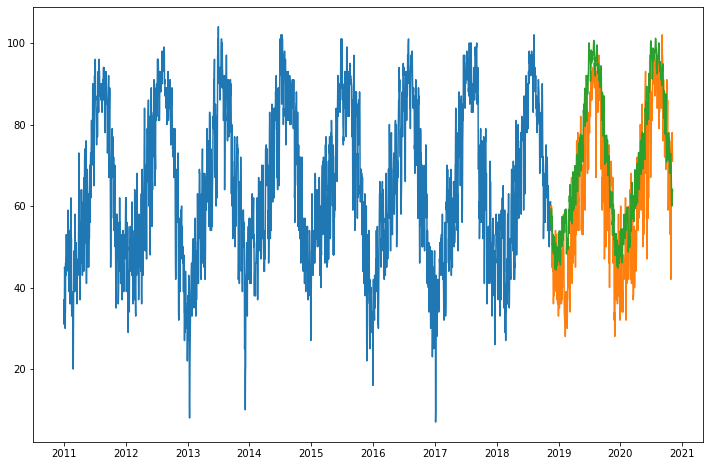

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(train.Datetime, train['DailyMaximumDryBulbTemperature'], label='Train')
plt.plot(test.Datetime, test['DailyMaximumDryBulbTemperature'], label='Test')
plt.plot(test.Datetime, df_res[2876:]['DailyMaximumDryBulbTemperature'], label='AR predict')
plt.show()

In [24]:
mse = mean_squared_error(test.DailyMaximumDryBulbTemperature, df_res[2876:].DailyMaximumDryBulbTemperature)
rmse = sqrt(mean_squared_error(test.DailyMaximumDryBulbTemperature, df_res[2876:].DailyMaximumDryBulbTemperature))
mse,rmse

(131.43865417355167, 11.464669824009398)